In [52]:
#DSCC275_Project3.1
#Xubin Lou, Jiayue Meng

In [40]:
#Given code
#!/usr/bin/env python
# coding: utf-8

# In[2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

# print('hello')

def findFiles(path): return glob.glob(path)

#print(findFiles('C:/Users/*.txt'))

# %% 

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# %%
# Build the names dictionary, a list of names per language
# di tionary keys are languages, values are names
names = {} #key:language, value:list of names
languages = [] #10

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# PLEASE UPDATE THE FILE PATH BELOW FOR YOUR SYSTEM
for filename in findFiles("/Users/carol/Desktop/data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''

findName(names,'Bernal')
findName(names,'Johnson')

# Now we have ``names``, a dictionary mapping each category
# (language) to a list of lines (names). We also kept track of
# ``languages`` (just a list of languages) and ``n_categories`` for
# later reference.
# 

# print(names['Italian'][:5])

# %% 
# Turning Names into Tensors
# --------------------------
# 
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
# 
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
# 
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
# 
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# print(letterToTensor('J'))

# print(nameToTensor('Jones').size())


# %% Creating the Network
# ====================
# 
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
# 
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
# 
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:



tensor([[-3.0991, -2.6811, -2.8775, -2.7995, -2.8696, -3.0722, -3.0651, -2.9071,
         -2.9520, -2.8438, -2.8621, -2.9192, -2.9302, -2.8265, -2.8068, -2.8699,
         -3.0305, -2.7270]], grad_fn=<LogSoftmaxBackward0>)
('German', 1)
category = Portuguese / name = Campos
category = English / name = Foucher
category = Russian / name = Finochkin
category = Polish / name = Bosko
category = Scottish / name = Martin
category = Portuguese / name = Palmeiro
category = Vietnamese / name = Dang
category = German / name = Voigt
category = Chinese / name = Gui
category = Spanish / name = Acosta
5000 5% (0m 3s) 2.4179 Damiani / Italian ✓
10000 10% (0m 7s) 2.4166 Psik / Polish ✗ (Czech)
15000 15% (0m 11s) 1.8421 Ansaldi / Italian ✓
20000 20% (0m 14s) 2.4494 Maloof / Arabic ✓
25000 25% (0m 18s) 2.6443 Farnworth / Russian ✗ (English)
30000 30% (0m 22s) 1.6049 Ferguson / Scottish ✓
35000 35% (0m 26s) 1.7256 Fabre / French ✓
40000 40% (0m 29s) 2.1628 Milligan / Irish ✗ (English)
45000 45% (0m 33s) 3.

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1926937810.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1926937810.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


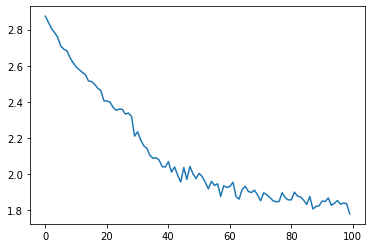

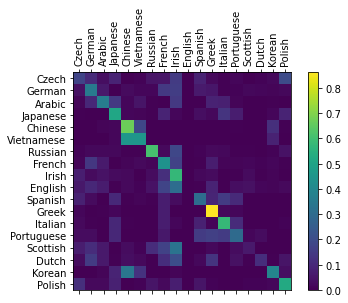

In [17]:
# 1.1
# hidden state size: 2

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 2 
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

 
#You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
# 

# CODE below is for illustration only
# Running on User Input
# ---------------------
# 

# In[15]:

tensor([[-3.1753, -2.9000, -2.7066, -2.7412, -2.8400, -3.0229, -2.7410, -3.0086,
         -2.8967, -2.9499, -2.8809, -2.9269, -2.9749, -2.9793, -2.9826, -2.8785,
         -2.8218, -2.7252]], grad_fn=<LogSoftmaxBackward0>)
('Arabic', 2)
category = Portuguese / name = Pinho
category = Polish / name = Kowalski
category = Scottish / name = Scott
category = Arabic / name = Guirguis
category = Portuguese / name = Esteves
category = English / name = Batt
category = Korean / name = Ho
category = Arabic / name = Sayegh
category = Scottish / name = Davidson
category = Chinese / name = Pang
5000 5% (0m 3s) 2.8056 Youj / German ✗ (Korean)
10000 10% (0m 7s) 2.0860 Accosi / Italian ✓
15000 15% (0m 11s) 1.9216 Pinheiro / Portuguese ✓
20000 20% (0m 15s) 2.6142 Carey / English ✗ (Irish)
25000 25% (0m 18s) 2.0696 Malouf / Arabic ✓
30000 30% (0m 22s) 2.2936 Duncan / Irish ✗ (Scottish)
35000 35% (0m 27s) 1.4050 Marszaek / Polish ✓
40000 40% (0m 30s) 3.1784 Cook / Korean ✗ (English)
45000 45% (0m 34s) 1.54

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/2035975831.py:248: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/2035975831.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


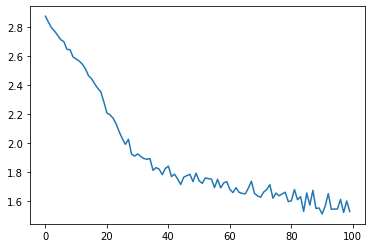

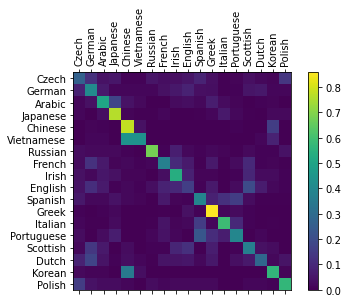

In [3]:
# 1.1
# hidden state size: 8

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

tensor([[-2.7965, -2.8476, -3.0153, -2.7546, -2.7567, -3.0043, -2.8199, -2.9450,
         -2.8557, -2.9510, -2.9209, -2.8332, -2.9676, -2.9406, -3.0171, -2.8276,
         -2.9454, -2.8899]], grad_fn=<LogSoftmaxBackward0>)
('Japanese', 3)
category = English / name = Gunter
category = Italian / name = Naggia
category = Spanish / name = Maria
category = Polish / name = Janowski
category = Japanese / name = Shibaguchi
category = Italian / name = Bandini
category = German / name = Seidel
category = English / name = Mcleod
category = Portuguese / name = Salazar
category = Irish / name = O'Hara
5000 5% (0m 3s) 2.7945 Dumont / French ✗ (English)
10000 10% (0m 6s) 3.1891 Marti / Italian ✗ (Spanish)
15000 15% (0m 9s) 2.1056 Russell / Scottish ✓
20000 20% (0m 13s) 4.1527 Tenshin / Irish ✗ (Japanese)
25000 25% (0m 16s) 2.4250 Attia / Czech ✗ (Arabic)
30000 30% (0m 19s) 2.4087 Diep / Dutch ✗ (Vietnamese)
35000 35% (0m 22s) 2.2910 Black / Scottish ✗ (English)
40000 40% (0m 26s) 2.0532 Bruce / French

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/3782764622.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/3782764622.py:252: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


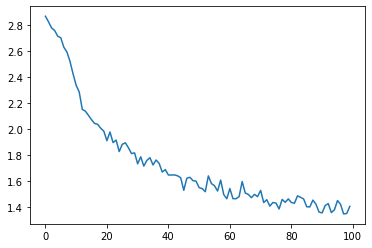

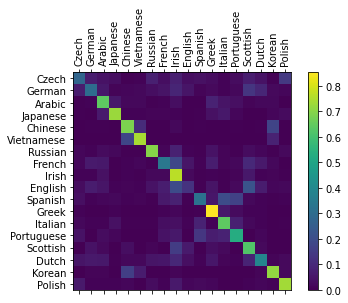

In [51]:
# 1.1
# hidden state size: 32

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

tensor([[-2.9049, -2.8075, -2.9109, -2.8234, -2.7677, -2.8145, -2.9460, -2.9864,
         -2.8231, -2.9230, -2.9020, -3.0906, -3.0406, -2.8584, -2.8212, -2.9281,
         -3.1023, -2.6799]], grad_fn=<LogSoftmaxBackward0>)
('Polish', 17)
category = Italian / name = Allegri
category = Czech / name = Ondrisek
category = Korean / name = You
category = French / name = Pascal
category = Arabic / name = Khoury
category = Spanish / name = Fonseca
category = Portuguese / name = Pinheiro
category = English / name = Debenham
category = Italian / name = Provenza
category = Russian / name = Bawvykin
5000 5% (0m 4s) 4.3888 Antonakos / Russian ✗ (Greek)
10000 10% (0m 9s) 1.6117 Morcos / English ✗ (Arabic)
15000 15% (0m 15s) 3.8108 Lebeau / English ✗ (French)
20000 20% (0m 20s) 0.3147 Zhadin / Russian ✓
25000 25% (0m 24s) 3.0375 Dirchs / English ✗ (German)
30000 30% (0m 29s) 0.0677 Zogalev / Russian ✓
35000 35% (0m 34s) 1.0120 Bull / English ✓
40000 40% (0m 38s) 0.0528 Ageichev / Russian ✓
45000 45% (

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/3588360928.py:260: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/3588360928.py:261: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


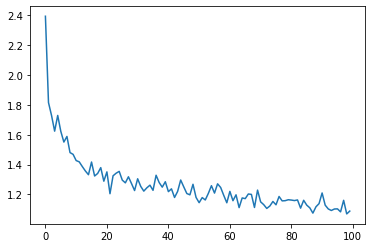

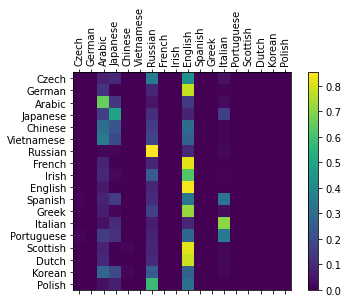

In [5]:
# 1.2
# hidden state size: 2

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 2 
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

#list comprehension:
list_data=[]
for category in languages:
    for name in names[category]:
        list_data.append((name, category))
iter=0
for _ in range(5):
    random.shuffle(list_data)
    for name, category in list_data: # all language+ name   #can use shuffle to get go through all ramdonly
    #     category, name, category_tensor, name_tensor = randomTrainingExample()
        iter+=1
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

 
#You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
# 

# CODE below is for illustration only
# Running on User Input
# ---------------------
# 

# In[15]:



tensor([[-2.9353, -2.9388, -2.8134, -2.8553, -2.8673, -2.6733, -2.7861, -2.9074,
         -2.9950, -3.0152, -2.8602, -2.9903, -2.9120, -3.0619, -2.9107, -2.8550,
         -2.9445, -2.7825]], grad_fn=<LogSoftmaxBackward0>)
('Vietnamese', 5)
category = Italian / name = Brivio
category = Czech / name = Abl
category = Spanish / name = Aqua
category = Portuguese / name = Maria
category = Chinese / name = Yap
category = Chinese / name = Zeng
category = Scottish / name = Gibson
category = Scottish / name = Murray
category = Korean / name = Baik
category = Polish / name = Gwozdek
5000 5% (0m 3s) 0.2464 Mohorov / Russian ✓
10000 10% (0m 7s) 1.2006 Bata / Arabic ✓
15000 15% (0m 12s) 1.2402 Lygach / Russian ✓
20000 20% (0m 16s) 0.9448 John / English ✓
25000 25% (0m 20s) 0.5311 Eastwood / English ✓
30000 30% (0m 24s) 0.0056 Yuhvidov / Russian ✓
35000 35% (0m 28s) 0.0084 Polikashkin / Russian ✓
40000 40% (0m 32s) 1.2403 Molin / English ✗ (Russian)
45000 45% (0m 36s) 0.4532 Zobkob / Russian ✓
50000 

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1668864094.py:259: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1668864094.py:260: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


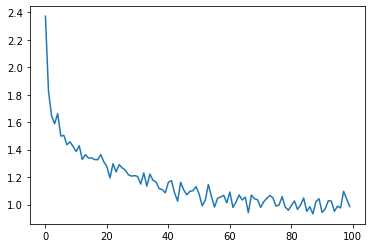

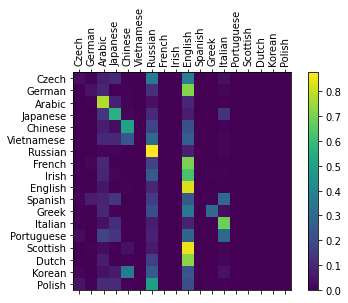

In [6]:
# 1.2
# hidden state size: 8
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

#list comprehension:
list_data=[]
for category in languages:
    for name in names[category]:
        list_data.append((name, category))
iter=0
for _ in range(5):
    random.shuffle(list_data)
    for name, category in list_data: # all language+ name   #can use shuffle to get go through all ramdonly
    #     category, name, category_tensor, name_tensor = randomTrainingExample()
        iter+=1
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()



tensor([[-2.9086, -2.7549, -3.0564, -2.8055, -2.7752, -2.8920, -2.9386, -2.8510,
         -2.9447, -2.9709, -2.7793, -2.8501, -3.0255, -2.9065, -2.8925, -2.8796,
         -3.0039, -2.8545]], grad_fn=<LogSoftmaxBackward0>)
('German', 1)
category = Japanese / name = Shunsen
category = Greek / name = Calogerakis
category = Greek / name = Forakis
category = Korean / name = So
category = Czech / name = Kreutschmer
category = German / name = Halle
category = Japanese / name = Muso
category = Arabic / name = Asghar
category = Spanish / name = Aritza
category = English / name = Kerr
5000 5% (0m 4s) 1.3990 Childs / English ✓
10000 10% (0m 8s) 1.3038 Waterman / Russian ✗ (English)
15000 15% (0m 12s) 0.2096 Mingalev / Russian ✓
20000 20% (0m 17s) 2.7760 Herschel / English ✗ (German)
25000 25% (0m 20s) 0.1513 Isachenko / Russian ✓
30000 30% (0m 24s) 2.2988 Kaddour / Arabic ✗ (English)
35000 35% (0m 29s) 0.6603 Salib / Arabic ✓
40000 40% (0m 33s) 3.0036 Sak / Chinese ✗ (Russian)
45000 45% (0m 37s) 

/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1516006569.py:259: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/0y/1xswhtb9233dmfpnjsyf9zb00000gn/T/ipykernel_84292/1516006569.py:260: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


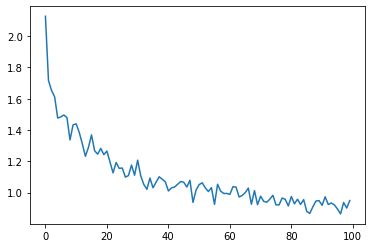

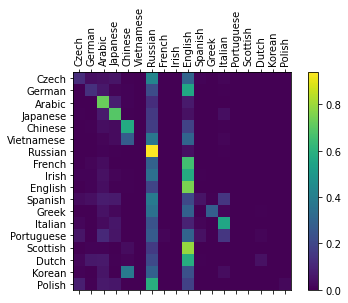

In [8]:
# 1.2
# hidden state size: 32
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#n_hidden = 128
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

#list comprehension:
list_data=[]
for category in languages:
    for name in names[category]:
        list_data.append((name, category))
iter=0
for _ in range(5):
    random.shuffle(list_data)
    for name, category in list_data: # all language+ name   #can use shuffle to get go through all ramdonly
    #     category, name, category_tensor, name_tensor = randomTrainingExample()
        iter+=1
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()



In [13]:
#2.1

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import pandas as pd
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# In[5]:


def findFiles(path): 
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# In[6]:q


names = {}
languages = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# (TO DO:) CHANGE FILE PATH AS NECESSARY
for filename in findFiles('/Users/carol/Desktop/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines


# In[7]:


n_categories = len(languages)

def letterToIndex(letter):
    return all_letters.find(letter)


def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# In[54]:


class RNN(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS,OUTPUT_SIZE):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True)
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        r_out, h = self.rnn(x, None) # None represents zero initial hidden state           
        out = self.out(r_out[:, -1, :])
        return out


# In[8]:

#list comprehension:
# list_data=[]
# for category in languages:
#     for name in names[category]:
#         list_data.append((name, category))

n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
# for category in list_data:
#     for name in names[category]:
#         allnames.append([name, category])
        
## (TO DO:) Determine Padding length (this is the length of the longest string) 
maxlen = max(len(name[0]) for name in allnames)
# maxlen = ..... # Add code here to compute the maximum length of string        
                
n_letters = len(all_letters)
n_categories = len(languages)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

           


# In[13]:


learning_rate = 0.005
rnn = RNN(n_letters, 128, 1, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()  

for epoch in range(5):  
    batch_size = len(allnames)
    random.shuffle(allnames)
    
    # if "b_in" and "b_out" are the variable names for input and output tensors, you need to create those
    
    b_in = torch.zeros(batch_size, maxlen, n_letters)  # (TO DO:) Initialize "b_in" to a tensor with size of input (batch size, padded_length, n_letters)
    b_out = torch.zeros(batch_size, n_categories, dtype=torch.long)  # (TO DO:) Initialize "b_out" to tensor with size (batch_size, n_categories, dtype=torch.long)       

    def split(word):
        return [char for char in word]
    # (TO DO:) Populate "b_in" tensor
    for name in allnames:
        i=allnames.index(name)       
        list1=split(name[0])
        for m in range(len(name[0])):
            b_in[i][m][letterToIndex(list1[m])]=1
        

    # (TO DO:) Populate "b_out" tensor
    for name in allnames:       
        i=allnames.index(name)       
        lan=name[1]
        l=languages.index(lan)
        b_out[i][l]=1
    
       
    labels=torch.max(b_out,1)[1]
    output = rnn(b_in)                               # rnn output
    #(TO DO:)
    loss = loss_func(output, labels)   # (TO DO:) Fill "...." to calculate the cross entropy loss
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()                                # apply gradients
        
    # Print accuracy
    test_output = rnn(b_in)                   # 
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    test_y = torch.max(b_out, 1)[1].data.numpy().squeeze()
    accuracy = sum(pred_y == test_y)/batch_size
    print("Epoch: ", epoch, "| train loss: %.4f" % loss.item(), '| accuracy: %.2f' % accuracy)
  

Epoch:  0 | train loss: 2.8928 | accuracy: 0.47
Epoch:  1 | train loss: 2.7251 | accuracy: 0.47
Epoch:  2 | train loss: 2.3789 | accuracy: 0.47
Epoch:  3 | train loss: 1.8889 | accuracy: 0.47
Epoch:  4 | train loss: 1.8981 | accuracy: 0.47


In [47]:
#2.2
#batch size=1000

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import pandas as pd
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# In[5]:


def findFiles(path): 
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# In[6]:q


names = {}
languages = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# (TO DO:) CHANGE FILE PATH AS NECESSARY
for filename in findFiles('/Users/carol/Desktop/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines


# In[7]:


n_categories = len(languages)

def letterToIndex(letter):
    return all_letters.find(letter)


def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# In[54]:


class RNN(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS,OUTPUT_SIZE):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True)
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        r_out, h = self.rnn(x, None) # None represents zero initial hidden state           
        out = self.out(r_out[:, -1, :])
        return out


# In[8]:

#list comprehension:
# list_data=[]
# for category in languages:
#     for name in names[category]:
#         list_data.append((name, category))

n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
        

def randomChoice(l, size):
    h=[]
    random.shuffle(l)
    for i in range(size):
        h.append(l[random.randint(0, len(l) - 1)])
        
    return h

allnames1000=randomChoice(allnames, 1000)

        
    
# for category in list_data:
#     for name in names[category]:
#         allnames.append([name, category])
        
## (TO DO:) Determine Padding length (this is the length of the longest string) 
maxlen = max(len(name[0]) for name in allnames1000)
# maxlen = ..... # Add code here to compute the maximum length of string        
                
n_letters = len(all_letters)
n_categories = len(languages)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

           


# In[13]:


learning_rate = 0.005
rnn = RNN(n_letters, 128, 1, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()  

for epoch in range(5):  
    batch_size = len(allnames1000)
    random.shuffle(allnames1000)
    
    # if "b_in" and "b_out" are the variable names for input and output tensors, you need to create those
    
    b_in = torch.zeros(batch_size, maxlen, n_letters)  # (TO DO:) Initialize "b_in" to a tensor with size of input (batch size, padded_length, n_letters)
    b_out = torch.zeros(batch_size, n_categories, dtype=torch.long)  # (TO DO:) Initialize "b_out" to tensor with size (batch_size, n_categories, dtype=torch.long)       

    def split(word):
        return [char for char in word]
    # (TO DO:) Populate "b_in" tensor
    for name in allnames1000:
        i=allnames1000.index(name)       
        list1=split(name[0])
        for m in range(len(name[0])):
            b_in[i][m][letterToIndex(list1[m])]=1
        

    # (TO DO:) Populate "b_out" tensor
    for name in allnames1000:       
        i=allnames1000.index(name)       
        lan=name[1]
        l=languages.index(lan)
        b_out[i][l]=1
    
       
    labels=torch.max(b_out,1)[1]
    output = rnn(b_in)                               # rnn output
    #(TO DO:)
    loss = loss_func(output, labels)   # (TO DO:) Fill "...." to calculate the cross entropy loss
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()                                # apply gradients
        
    # Print accuracy
    test_output = rnn(b_in)                   # 
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    test_y = torch.max(b_out, 1)[1].data.numpy().squeeze()
    accuracy = sum(pred_y == test_y)/batch_size
    print("Epoch: ", epoch, "| train loss: %.4f" % loss.item(), '| accuracy: %.3f' % accuracy)
  

Epoch:  0 | train loss: 2.8897 | accuracy: 0.461
Epoch:  1 | train loss: 2.7155 | accuracy: 0.461
Epoch:  2 | train loss: 2.4294 | accuracy: 0.461
Epoch:  3 | train loss: 1.9500 | accuracy: 0.461
Epoch:  4 | train loss: 1.9976 | accuracy: 0.461


In [48]:
#2.2
#batch size=2000

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import pandas as pd
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# In[5]:


def findFiles(path): 
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# In[6]:q


names = {}
languages = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# (TO DO:) CHANGE FILE PATH AS NECESSARY
for filename in findFiles('/Users/carol/Desktop/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines


# In[7]:


n_categories = len(languages)

def letterToIndex(letter):
    return all_letters.find(letter)


def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# In[54]:


class RNN(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS,OUTPUT_SIZE):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True)
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        r_out, h = self.rnn(x, None) # None represents zero initial hidden state           
        out = self.out(r_out[:, -1, :])
        return out


# In[8]:

#list comprehension:
# list_data=[]
# for category in languages:
#     for name in names[category]:
#         list_data.append((name, category))

n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
        

def randomChoice(l, size):
    h=[]
    random.shuffle(l)
    for i in range(size):
        h.append(l[random.randint(0, len(l) - 1)])
        
    return h

allnames2000=randomChoice(allnames, 2000)

        
    
# for category in list_data:
#     for name in names[category]:
#         allnames.append([name, category])
        
## (TO DO:) Determine Padding length (this is the length of the longest string) 
maxlen = max(len(name[0]) for name in allnames2000)
# maxlen = ..... # Add code here to compute the maximum length of string        
                
n_letters = len(all_letters)
n_categories = len(languages)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

           


# In[13]:


learning_rate = 0.005
rnn = RNN(n_letters, 128, 1, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()  

for epoch in range(5):  
    batch_size = len(allnames2000)
    random.shuffle(allnames2000)
    
    # if "b_in" and "b_out" are the variable names for input and output tensors, you need to create those
    
    b_in = torch.zeros(batch_size, maxlen, n_letters)  # (TO DO:) Initialize "b_in" to a tensor with size of input (batch size, padded_length, n_letters)
    b_out = torch.zeros(batch_size, n_categories, dtype=torch.long)  # (TO DO:) Initialize "b_out" to tensor with size (batch_size, n_categories, dtype=torch.long)       

    def split(word):
        return [char for char in word]
    # (TO DO:) Populate "b_in" tensor
    for name in allnames2000:
        i=allnames2000.index(name)       
        list1=split(name[0])
        for m in range(len(name[0])):
            b_in[i][m][letterToIndex(list1[m])]=1
        

    # (TO DO:) Populate "b_out" tensor
    for name in allnames2000:       
        i=allnames2000.index(name)       
        lan=name[1]
        l=languages.index(lan)
        b_out[i][l]=1
    
       
    labels=torch.max(b_out,1)[1]
    output = rnn(b_in)                               # rnn output
    #(TO DO:)
    loss = loss_func(output, labels)   # (TO DO:) Fill "...." to calculate the cross entropy loss
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()                                # apply gradients
        
    # Print accuracy
    test_output = rnn(b_in)                   # 
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    test_y = torch.max(b_out, 1)[1].data.numpy().squeeze()
    accuracy = sum(pred_y == test_y)/batch_size
    print("Epoch: ", epoch, "| train loss: %.4f" % loss.item(), '| accuracy: %.3f' % accuracy)
  

Epoch:  0 | train loss: 2.8700 | accuracy: 0.448
Epoch:  1 | train loss: 2.6591 | accuracy: 0.448
Epoch:  2 | train loss: 2.1291 | accuracy: 0.448
Epoch:  3 | train loss: 1.9578 | accuracy: 0.448
Epoch:  4 | train loss: 1.9865 | accuracy: 0.448


In [46]:
#2.2
#batch size=3000

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import pandas as pd
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# In[5]:


def findFiles(path): 
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# In[6]:q


names = {}
languages = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# (TO DO:) CHANGE FILE PATH AS NECESSARY
for filename in findFiles('/Users/carol/Desktop/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines


# In[7]:


n_categories = len(languages)

def letterToIndex(letter):
    return all_letters.find(letter)


def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# In[54]:


class RNN(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS,OUTPUT_SIZE):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True)
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        r_out, h = self.rnn(x, None) # None represents zero initial hidden state           
        out = self.out(r_out[:, -1, :])
        return out


# In[8]:

#list comprehension:
# list_data=[]
# for category in languages:
#     for name in names[category]:
#         list_data.append((name, category))

n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
        

def randomChoice(l, size):
    h=[]
    random.shuffle(l)
    for i in range(size):
        h.append(l[random.randint(0, len(l) - 1)])
        
    return h

allnames3000=randomChoice(allnames, 3000)

        
    
# for category in list_data:
#     for name in names[category]:
#         allnames.append([name, category])
        
## (TO DO:) Determine Padding length (this is the length of the longest string) 
maxlen = max(len(name[0]) for name in allnames3000)
# maxlen = ..... # Add code here to compute the maximum length of string        
                
n_letters = len(all_letters)
n_categories = len(languages)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

           


# In[13]:


learning_rate = 0.005
rnn = RNN(n_letters, 128, 1, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()  

for epoch in range(5):  
    batch_size = len(allnames3000)
    random.shuffle(allnames3000)
    
    # if "b_in" and "b_out" are the variable names for input and output tensors, you need to create those
    
    b_in = torch.zeros(batch_size, maxlen, n_letters)  # (TO DO:) Initialize "b_in" to a tensor with size of input (batch size, padded_length, n_letters)
    b_out = torch.zeros(batch_size, n_categories, dtype=torch.long)  # (TO DO:) Initialize "b_out" to tensor with size (batch_size, n_categories, dtype=torch.long)       

    def split(word):
        return [char for char in word]
    # (TO DO:) Populate "b_in" tensor
    for name in allnames3000:
        i=allnames3000.index(name)       
        list1=split(name[0])
        for m in range(len(name[0])):
            b_in[i][m][letterToIndex(list1[m])]=1
        

    # (TO DO:) Populate "b_out" tensor
    for name in allnames3000:       
        i=allnames3000.index(name)       
        lan=name[1]
        l=languages.index(lan)
        b_out[i][l]=1
    
       
    labels=torch.max(b_out,1)[1]
    output = rnn(b_in)                               # rnn output
    #(TO DO:)
    loss = loss_func(output, labels)   # (TO DO:) Fill "...." to calculate the cross entropy loss
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()                                # apply gradients
        
    # Print accuracy
    test_output = rnn(b_in)                   # 
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    test_y = torch.max(b_out, 1)[1].data.numpy().squeeze()
    accuracy = sum(pred_y == test_y)/batch_size
    print("Epoch: ", epoch, "| train loss: %.4f" % loss.item(), '| accuracy: %.3f' % accuracy)
  

Epoch:  0 | train loss: 2.8706 | accuracy: 0.444
Epoch:  1 | train loss: 2.6496 | accuracy: 0.444
Epoch:  2 | train loss: 2.1522 | accuracy: 0.444
Epoch:  3 | train loss: 1.9448 | accuracy: 0.444
Epoch:  4 | train loss: 1.9061 | accuracy: 0.444
